In [1]:
# These two lines allow for the notebook to automatically update to use the most
# up-to-date versions of the code being imported
%load_ext autoreload
%autoreload 2

import control as ct
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyphotonicsims.control_systems.control_core import *
from pyphotonicsims.control_systems.calculate_laser_noise import *

# plt.style.available
%matplotlib inline
plt.style.use('science')
plt.rcParams['figure.figsize'] = [4,3]

In [2]:
Pin = 1e-4 # input power 0.1mW
dv = 6e6  # cavity linewidth 6MHz
NEP = 4e-12# PD NEP 4pW/rtHz
Kv = 15e6  # 15 MHz/V
S_servo = 1e-14 # servo noise [V^2/Hz]
S_sh = get_S_shot(Pin, dv)
S_pd = get_S_PD(NEP, Pin, dv) # [Hz^2/Hz]
[S_sh,S_pd]

[0.002893995, 0.008999999999999996]

<img src="../figures/control_model_2.png" width="800"/>

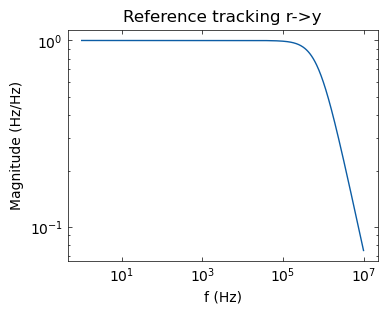

In [3]:
# architecture
# r ---> D ---> PID ---> L ---> y
#        |               |
#         ------<--------

freq_points = 500
s = ct.tf('s')
sys_ref = Kv/(1 + s/(2*np.pi*1e5))
laser = ControlModule(freq_points = freq_points, sys_ref = sys_ref, unit_in = 'V', unit_out = 'Hz', label = 'laser')
df = pd.read_csv('data/ML_FN_data.csv')
FN = df.values
FNx = S_noise_interp(FN[:,0],FN[:,1],laser.freqx)
laser.output_noise = FNx

sys_ref = 1 + 2*np.pi*1e5/s
servo = ControlModule(freq_points = freq_points, sys_ref = sys_ref, unit_in = 'V', unit_out = 'V', label = 'servo')
servo.output_noise = S_servo*(1 + 1e12*np.ones(freq_points)/servo.freqx**2)

Dv = 0.5e-6 # error discrimination Dv = 0.5V/MHz [V/Hz]
sys_ref = Dv
disc = ControlModule(freq_points = freq_points, sys_ref = sys_ref, unit_in = 'Hz', unit_out = 'V', label = 'freq disc')
disc.output_noise = np.ones(len(disc.freqx))*S_pd*Dv**2

C_list = [disc, servo, laser]
pdh = feedback_combine(C_list, 2)
pdh.input_noise = get_S_TRN(laser.freqx)
pdh.freqresp_module_update()

pdh.plot_ref_tracking()

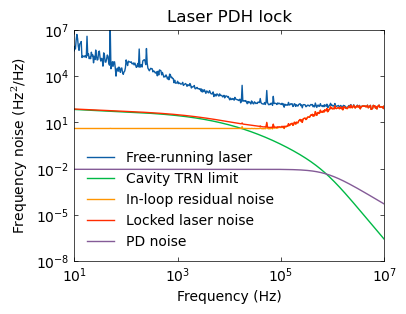

In [4]:
pdh.plot_module_noise()
plt.loglog(pdh.freqx,pdh.block_output_noise_transferred[0])
plt.legend(('Free-running laser','Cavity TRN limit','In-loop residual noise','Locked laser noise','PD noise'), loc = 'lower left')
plt.xlim((10,1e7))
plt.ylim((1e-8,1e7))
plt.ylabel('Frequency noise (Hz$^2$/Hz)')
plt.title('Laser PDH lock')
plt.savefig('laser_pdh_lock.png',dpi = 1000, bbox_inches = 'tight')

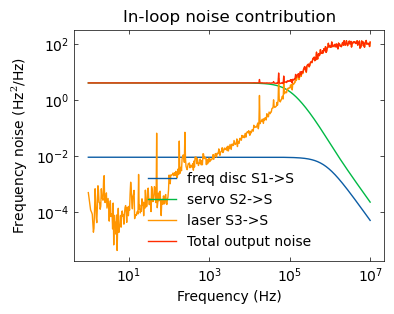

In [5]:
pdh.plot_module_noise_decomposition()
plt.ylabel('Frequency noise (Hz$^2$/Hz)')
plt.title('In-loop noise contribution')
plt.savefig('laser_pdh_lock_inloop.png',dpi = 1000, bbox_inches = 'tight')